In [1]:
# import sys
# !{sys.executable} -m pip install raster2xyz
from osgeo import gdal
import fiona
import os
import urllib.request
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import rasterio as rio
import xarray as xr
import os
import numpy as np
from rasterio.warp import transform
from os.path import join
from glob import glob
from tqdm import tqdm
import rioxarray as rxr
import rasterio.mask
import rasterstats as rst
import pandas as pd
from PIL import Image
import tifftools
import pyproj
import raster2xyz
import io
import sys
from raster2xyz.raster2xyz import Raster2xyz
import warnings
warnings.filterwarnings('ignore')
#Supress default INFO logging

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [2]:
dem_path = "/home/sa42/data/glac/RGI_TOPO/extracted_dem_files/MAPZEN"
mask_path = "/home/sa42/data/glac/RGI_TOPO/extracted_mask_files"

dem_csv_path = "/home/sa42/data/glac/RGI_TOPO/extracted_dem_csv_files/"
mask_csv_path = "/home/sa42/data/glac/RGI_TOPO/extracted_mask_csv_files/"

dem_path_full = join(dem_path,"*.tif")
for file in tqdm(glob(dem_path_full)):
    file_left = file[57:]
    RGI_file = file_left[:14]
    
    dem_file = RGI_file + "_dem.tif"
    dem = join(dem_path, dem_file)
    
    mask_file = RGI_file + "_glacier_mask.tif"
    mask = join(mask_path, mask_file)
    
    dem_csv = join(dem_csv_path, RGI_file + "_dem_trans.csv")
    mask_csv = join(mask_csv_path, RGI_file + "_mask_trans.csv")
    
    print(RGI_file)
    print(dem)
    print(dem_csv)
    print(mask)
    print(mask_csv)
#     transmogrifyer(mask)
#     dir_out_mask = "/home/sa42/data/glac/RGI_TOPO/extracted_mask_csv_files/"
#     mask_out = join(dir_out_mask,RGI_file + "_mask_trans.csv")

#     testy_out_path = "/home/sa42/data/glac/RGI_TOPO/testy_testy"
#     testy_out = join(testy_out_path, RGI_file + \.csv\)
#     input_raster = dem
#     rtxyz = Raster2xyz()
#     rtxyz.translate(input_raster, testy_out)
#     testy = pd.DataFrame(testy_out)
#     testy.to_csv(test.csv)
#     mask_data = pd.read_csv(test.csv)
    break

dem_reader = xr.open_rasterio(dem)
ny, nx = len(dem_reader['y']), len(dem_reader['x'])
x, y = np.meshgrid(dem_reader['x'], dem_reader['y'])
lon, lat = transform(dem_reader.crs, {'init': 'EPSG:4326'},
                 x.flatten(), y.flatten())

  0%|          | 0/216500 [00:00<?, ?it/s]

RGI60-19.02001
/home/sa42/data/glac/RGI_TOPO/extracted_dem_files/MAPZEN/RGI60-19.02001_dem.tif
/home/sa42/data/glac/RGI_TOPO/extracted_dem_csv_files/RGI60-19.02001_dem_trans.csv
/home/sa42/data/glac/RGI_TOPO/extracted_mask_files/RGI60-19.02001_glacier_mask.tif
/home/sa42/data/glac/RGI_TOPO/extracted_mask_csv_files/RGI60-19.02001_mask_trans.csv


In [3]:
def transmogrifyer(dem):
    dem_reader = xr.open_rasterio(dem)
    ny, nx = len(dem_reader['y']), len(dem_reader['x'])
    x, y = np.meshgrid(dem_reader['x'], dem_reader['y'])
    lon, lat = transform(dem_reader.crs, {'init': 'EPSG:4326'},
                     x.flatten(), y.flatten())
    
    dem_lon = np.asarray(lon).reshape((ny, nx))
    dem_lat = np.asarray(lat).reshape((ny, nx))
    dem_reader.coords['lon'] = (('y', 'x'), dem_lon)
    dem_reader.coords['lat'] = (('y', 'x'), dem_lat)
    dem_greyscale = dem_reader.mean(dim="band")
    
    ax = plt.subplot(projection=ccrs.PlateCarree())
    dem_plot = dem_greyscale.plot(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(),
                                  cmap='Greys_r', add_colorbar=False, shading=None)
    

def plotter(mask_data):
    X = mask_data['x'].values.reshape(ny,nx).T
    Y = mask_data['y'].values.reshape(ny,nx).T
    Z = mask_data['z'].values.reshape(ny,nx).T

    plt.pcolormesh(X,Y,Z)
    plt.show()

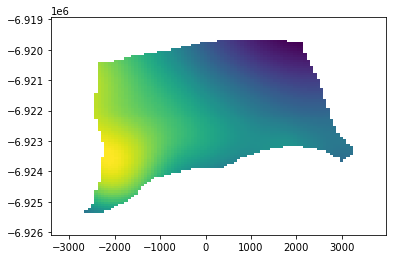

In [4]:
mask_data = pd.read_csv(mask_csv)
mask_data.rename(columns = {"z":"z_mask"}, inplace=True)


dem_data = pd.read_csv(dem_csv)
mask_and_dem = pd.merge(mask_data, dem_data, how="inner")


# mask_and_dem = mask_and_dem[mask_and_dem["z_mask"] !=0]
# mask_and_dem = mask_and_dem.drop("z_mask",axis=1)

RGI = pd.read_csv("RGI.csv")
mask_and_dem = mask_and_dem.assign(RGIId = RGI_file)
# f = pd.merge(RGI,mask_and_dem, how = "inner" )
# f.to_csv("/home/sa42/data/glac/RGI_TOPO/compiled_csv_files/" + RGI_file + ".csv")
mask_and_dem.loc[mask_and_dem["z_mask"] == 0,"z"] = np.nan

plotter(mask_and_dem)

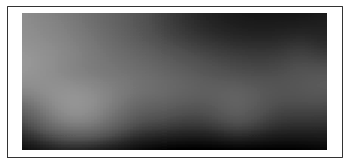

In [5]:
transmogrifyer(dem)

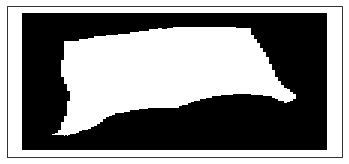

In [6]:
transmogrifyer(mask)

In [7]:
mask_and_dem.loc[mask_and_dem["z_mask"] == 0,"z"]
# mask_and_dem = mask_and_dem[mask_and_dem["z_mask"] != 0]
# mask_and_dem = mask_and_dem[mask_and_dem["z"] != 0]
# mask_and_dem = mask_and_dem.drop("z_mask",axis = 1)
# mask_and_dem = mask_and_dem.drop("x",axis = 1)
# mask_and_dem = mask_and_dem.drop("y",axis = 1)
mask_and_dem = mask_and_dem.assign(RGIId = RGI_file)
RGI = pd.read_csv("~/notebooks/glac/RGI/RGI.csv")
RGI = pd.merge(RGI, mask_and_dem, how = "inner", on="RGIId")
# RGI

In [8]:
dem_reader = xr.open_rasterio(dem)
ny, nx = len(dem_reader['y']), len(dem_reader['x'])
x, y = np.meshgrid(dem_reader['x'], dem_reader['y'])
lon, lat = transform(dem_reader.crs, {'init': 'EPSG:4326'},
                 x.flatten(), y.flatten())
    
dem_lon = np.asarray(lon).reshape((ny, nx))
dem_lat = np.asarray(lat).reshape((ny, nx))
dem_reader.coords['lon'] = (('y', 'x'), dem_lon)
dem_reader.coords['lat'] = (('y', 'x'), dem_lat)

testy_testy = "/home/sa42/data/glac/RGI_TOPO/testy_testy"
dem_reader.coords['lat'].to_pandas().to_csv(testy_testy + RGI_file + "lat.csv")
dem_reader.coords['lon'].to_pandas().to_csv(testy_testy + RGI_file + "lon.csv")

pp_lon = pd.read_csv(testy_testy + RGI_file + "lon.csv")
pp_lat = pd.read_csv(testy_testy + RGI_file + "lat.csv")
pp = pd.merge(pp_lat, pp_lon, how="inner", on = "y")
pp_lat

,y,-3359.5818707992235,-3286.5818707992235,-3213.5818707992235,-3140.5818707992235,-3067.5818707992235,-2994.5818707992235,-2921.5818707992235,-2848.5818707992235,-2775.5818707992235,...,3283.4181292007765,3356.4181292007765,3429.4181292007765,3502.4181292007765,3575.4181292007765,3648.4181292007765,3721.4181292007765,3794.4181292007765,3867.4181292007765,3940.4181292007765
0,-6.918970e+06,-62.402028,-62.402029,-62.402030,-62.402030,-62.402031,-62.402032,-62.402032,-62.402033,-62.402033,...,-62.402029,-62.402028,-62.402028,-62.402027,-62.402026,-62.402026,-62.402025,-62.402024,-62.402023,-62.402023
1,-6.919043e+06,-62.402684,-62.402684,-62.402685,-62.402686,-62.402686,-62.402687,-62.402687,-62.402688,-62.402688,...,-62.402684,-62.402684,-62.402683,-62.402682,-62.402682,-62.402681,-62.402680,-62.402679,-62.402679,-62.402678
2,-6.919116e+06,-62.403339,-62.403340,-62.403340,-62.403341,-62.403341,-62.403342,-62.403343,-62.403343,-62.403344,...,-62.403340,-62.403339,-62.403338,-62.403338,-62.403337,-62.403336,-62.403335,-62.403335,-62.403334,-62.403333
3,-6.919189e+06,-62.403994,-62.403995,-62.403995,-62.403996,-62.403997,-62.403997,-62.403998,-62.403998,-62.403999,...,-62.403995,-62.403994,-62.403994,-62.403993,-62.403992,-62.403991,-62.403991,-62.403990,-62.403989,-62.403988
4,-6.919262e+06,-62.404649,-62.404650,-62.404651,-62.404651,-62.404652,-62.404653,-62.404653,-62.404654,-62.404654,...,-62.404650,-62.404649,-62.404649,-62.404648,-62.404647,-62.404647,-62.404646,-62.404645,-62.404644,-62.404644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,-6.925759e+06,-62.462967,-62.462967,-62.462968,-62.462968,-62.462969,-62.462970,-62.462970,-62.462971,-62.462971,...,-62.462967,-62.462967,-62.462966,-62.462965,-62.462965,-62.462964,-62.462963,-62.462962,-62.462962,-62.462961
94,-6.925832e+06,-62.463622,-62.463622,-62.463623,-62.463624,-62.463624,-62.463625,-62.463626,-62.463626,-62.463627,...,-62.463622,-62.463622,-62.463621,-62.463620,-62.463620,-62.463619,-62.463618,-62.463618,-62.463617,-62.463616
95,-6.925905e+06,-62.464277,-62.464278,-62.464278,-62.464279,-62.464280,-62.464280,-62.464281,-62.464281,-62.464282,...,-62.464278,-62.464277,-62.464276,-62.464276,-62.464275,-62.464274,-62.464274,-62.464273,-62.464272,-62.464271
96,-6.925978e+06,-62.464932,-62.464933,-62.464934,-62.464934,-62.464935,-62.464935,-62.464936,-62.464937,-62.464937,...,-62.464933,-62.464932,-62.464932,-62.464931,-62.464930,-62.464930,-62.464929,-62.464928,-62.464927,-62.464927


In [9]:
yp = pp_lon["y"]

In [10]:
# repeat above process but for lon
#drop y column, to be added back later.
pp_lat = pp_lat.drop("y",axis=1)
# move lat column names into a dataframe of their own
col_names = pd.Series(np.array(pp_lat.columns.tolist()))
col_names = col_names.apply(pd.to_numeric)
# # define range for renaming pp_lat columns and put into DataFrame
num_cols = len(list(pp_lat))
rng = range(1, int((num_cols / 2)) + 1)
# rename columns and merge back in y column
pp_lat.columns = col_names
pp_lat=pd.merge(pp_lat, yp, left_index=True, right_index=True)



# repeat above process but for lon
#drop y column, to be added back later.
pp_lon = pp_lon.drop("y",axis=1)
# move lat column names into a dataframe of their own
col_names = pd.Series(np.array(pp_lon.columns.tolist()))
col_names = col_names.apply(pd.to_numeric)
num_cols = len(list(pp_lon))
rng = range(1, int((num_cols / 2)) + 1)
# rename columns and merge back in y column
pp_lon.columns = col_names
pp_lon=pd.merge(pp_lon, yp, left_index=True, right_index=True)

In [11]:
# This loop works in theory but takes so friggen long to run it's not worth it. Needs modifying.

test=RGI
for x in tqdm(RGI["x"]):
    for y in RGI["y"]:
        for a in pp_lat:
            for b in pp_lat["y"]:
                if a == x and y ==b:
                    q = pp_lon[pp_lat["y"] == y].index
#                     print(q)
                    f = pp_lat[x].loc[q]
#                     print(f)
                    test = test.assign(lat=f)
                break
            break
        break
    break
                    
               
for x in RGI["x"]:
    for y in RGI["y"]:
        for a in pp_lon:
            for b in pp_lon["y"]:
                if a == x and y ==b:
                    q = pp_lon[pp_lon["y"] == y].index
                    print(q)
                    f = pp_lon[x].loc[q]
                    print(f)
                    test = test.assign(lon=f)
                break
            break
        break
    break

  0%|          | 0/9898 [00:00<?, ?it/s]

Int64Index([0], dtype='int64')
0   -59.5173
Name: -3359.5818707992235, dtype: float64


In [12]:
test

,RGIId,GLIMSId,x,y,z_mask,z,lat,lon
0,RGI60-19.02001,G300548E62430S,-3359.581871,-6.918970e+06,0,NaN,-62.402028,-59.5173
1,RGI60-19.02001,G300548E62430S,-3286.581871,-6.918970e+06,0,NaN,NaN,NaN
2,RGI60-19.02001,G300548E62430S,-3213.581871,-6.918970e+06,0,NaN,NaN,NaN
3,RGI60-19.02001,G300548E62430S,-3140.581871,-6.918970e+06,0,NaN,NaN,NaN
4,RGI60-19.02001,G300548E62430S,-3067.581871,-6.918970e+06,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
9893,RGI60-19.02001,G300548E62430S,3648.418129,-6.926051e+06,0,NaN,NaN,NaN
9894,RGI60-19.02001,G300548E62430S,3721.418129,-6.926051e+06,0,NaN,NaN,NaN
9895,RGI60-19.02001,G300548E62430S,3794.418129,-6.926051e+06,0,NaN,NaN,NaN
9896,RGI60-19.02001,G300548E62430S,3867.418129,-6.926051e+06,0,NaN,NaN,NaN


In [50]:
pp_lat["y"].app(to_numeric)

AttributeError: 'Series' object has no attribute 'app'

In [14]:
x_list = pp_lat.columns.tolist()
y_list = pp_lat["y"]

In [49]:
for x in tqdm(x_list):
    if [RGI.x == x]:
        q = RGI.index[RGI.x == x]
        print("x = "+str(x))
        for y in y_list:
            if [RGI.y == y] and [RGI.x == x]:
                print("")
                print("y = " + str(y))
                print("")
                print("index of RGI where x = " + str(x) + " and y = " + str(y))
                idx = (RGI.index[RGI.x == x] & RGI.index[RGI.y == y])
                print(idx)
                print("")
                print("")
                print(RGI.loc[idx])
                print("")
                cooleo = pp_lat[x == RGI.x].loc[y == RGI.y]
                shooleo = pp_lon[x == RGI.x].loc[y == RGI.y]
                lat = cooleo[x].loc[y==RGI.y]
                lon = shooleo[x].loc[y==RGI.y]
                
#             
                print("")
                RGI.loc[idx]["lat"]=lat
                print("")
                print("Required Latitude")
                print(lat)
                print("")
                print("Required Longitude")
                print(lon)
                print("")
                print("end")
#                 print("index of pp_lat where column_name = " + str(x) + " and y = " + str(y))

                RGI.loc[idx]["latitude"] = lat
                RGI.loc[idx]["longitude"] = lon
#                 print(RGI)
            elif [RGI.y != y] or [RGI.x != x]:
                break
#             break
        break
        


  0%|          | 0/102 [00:00<?, ?it/s]

x = -3359.5818707992235

y = -6918969.513301358

index of RGI where x = -3359.5818707992235 and y = -6918969.513301358
Int64Index([0], dtype='int64')


            RGIId         GLIMSId            x             y  z_mask   z
0  RGI60-19.02001  G300548E62430S -3359.581871 -6.918970e+06       0 NaN



Required Latitude
0   -62.402028
Name: -3359.5818707992235, dtype: float64

Required Longitude
0   -59.5173
Name: -3359.5818707992235, dtype: float64

end

y = -6919042.513301358

index of RGI where x = -3359.5818707992235 and y = -6919042.513301358
Int64Index([101], dtype='int64')


              RGIId         GLIMSId            x             y  z_mask   z
101  RGI60-19.02001  G300548E62430S -3359.581871 -6.919043e+06       0 NaN



Required Latitude
Series([], Name: -3359.5818707992235, dtype: float64)

Required Longitude
Series([], Name: -3359.5818707992235, dtype: float64)

end

y = -6919115.513301358

index of RGI where x = -3359.5818707992235 and y = -6919115.513301358
Int64Index([202



Required Latitude
Series([], Name: -3359.5818707992235, dtype: float64)

Required Longitude
Series([], Name: -3359.5818707992235, dtype: float64)

end

y = -6920940.513301358

index of RGI where x = -3359.5818707992235 and y = -6920940.513301358
Int64Index([2727], dtype='int64')


               RGIId         GLIMSId            x             y  z_mask   z
2727  RGI60-19.02001  G300548E62430S -3359.581871 -6.920941e+06       0 NaN



Required Latitude
Series([], Name: -3359.5818707992235, dtype: float64)

Required Longitude
Series([], Name: -3359.5818707992235, dtype: float64)

end

y = -6921013.513301358

index of RGI where x = -3359.5818707992235 and y = -6921013.513301358
Int64Index([2828], dtype='int64')


               RGIId         GLIMSId            x             y  z_mask   z
2828  RGI60-19.02001  G300548E62430S -3359.581871 -6.921014e+06       0 NaN



Required Latitude
Series([], Name: -3359.5818707992235, dtype: float64)

Required Longitude
Series([], Name: -3359.581870799

5151  RGI60-19.02001  G300548E62430S -3359.581871 -6.922693e+06       0 NaN



Required Latitude
Series([], Name: -3359.5818707992235, dtype: float64)

Required Longitude
Series([], Name: -3359.5818707992235, dtype: float64)

end

y = -6922765.513301358

index of RGI where x = -3359.5818707992235 and y = -6922765.513301358
Int64Index([5252], dtype='int64')


               RGIId         GLIMSId            x             y  z_mask   z
5252  RGI60-19.02001  G300548E62430S -3359.581871 -6.922766e+06       0 NaN



Required Latitude
Series([], Name: -3359.5818707992235, dtype: float64)

Required Longitude
Series([], Name: -3359.5818707992235, dtype: float64)

end

y = -6922838.513301358

index of RGI where x = -3359.5818707992235 and y = -6922838.513301358
Int64Index([5353], dtype='int64')


               RGIId         GLIMSId            x             y  z_mask   z
5353  RGI60-19.02001  G300548E62430S -3359.581871 -6.922839e+06       0 NaN



Required Latitude
Series([], Name: -3359.581870


y = -6924444.513301358

index of RGI where x = -3359.5818707992235 and y = -6924444.513301358
Int64Index([7575], dtype='int64')


               RGIId         GLIMSId            x             y  z_mask   z
7575  RGI60-19.02001  G300548E62430S -3359.581871 -6.924445e+06       0 NaN



Required Latitude
Series([], Name: -3359.5818707992235, dtype: float64)

Required Longitude
Series([], Name: -3359.5818707992235, dtype: float64)

end

y = -6924517.513301358

index of RGI where x = -3359.5818707992235 and y = -6924517.513301358
Int64Index([7676], dtype='int64')


               RGIId         GLIMSId            x             y  z_mask   z
7676  RGI60-19.02001  G300548E62430S -3359.581871 -6.924518e+06       0 NaN



Required Latitude
Series([], Name: -3359.5818707992235, dtype: float64)

Required Longitude
Series([], Name: -3359.5818707992235, dtype: float64)

end

y = -6924590.513301358

index of RGI where x = -3359.5818707992235 and y = -6924590.513301358
Int64Index([7777], dtype='int64

  0%|          | 0/102 [00:01<?, ?it/s]



Required Latitude
Series([], Name: -3359.5818707992235, dtype: float64)

Required Longitude
Series([], Name: -3359.5818707992235, dtype: float64)

end

y = -6925320.513301358

index of RGI where x = -3359.5818707992235 and y = -6925320.513301358
Int64Index([8787], dtype='int64')


               RGIId         GLIMSId            x             y  z_mask   z
8787  RGI60-19.02001  G300548E62430S -3359.581871 -6.925321e+06       0 NaN



Required Latitude
Series([], Name: -3359.5818707992235, dtype: float64)

Required Longitude
Series([], Name: -3359.5818707992235, dtype: float64)

end

y = -6925393.513301358

index of RGI where x = -3359.5818707992235 and y = -6925393.513301358
Int64Index([8888], dtype='int64')


               RGIId         GLIMSId            x             y  z_mask   z
8888  RGI60-19.02001  G300548E62430S -3359.581871 -6.925394e+06       0 NaN



Required Latitude
Series([], Name: -3359.5818707992235, dtype: float64)

Required Longitude
Series([], Name: -3359.581870799

In [19]:

x_list = pp_lat.columns.tolist()
y_list = pp_lat["y"]

idx = (RGI.index[RGI.x == x_list] & RGI.index[RGI.y == y_list])

ValueError: ('Lengths must match to compare', (9898,), (102,))

In [16]:
RGI

,RGIId,GLIMSId,x,y,z_mask,z
0,RGI60-19.02001,G300548E62430S,-3359.581871,-6.918970e+06,0,NaN
1,RGI60-19.02001,G300548E62430S,-3286.581871,-6.918970e+06,0,NaN
2,RGI60-19.02001,G300548E62430S,-3213.581871,-6.918970e+06,0,NaN
3,RGI60-19.02001,G300548E62430S,-3140.581871,-6.918970e+06,0,NaN
4,RGI60-19.02001,G300548E62430S,-3067.581871,-6.918970e+06,0,NaN
...,...,...,...,...,...,...
9893,RGI60-19.02001,G300548E62430S,3648.418129,-6.926051e+06,0,NaN
9894,RGI60-19.02001,G300548E62430S,3721.418129,-6.926051e+06,0,NaN
9895,RGI60-19.02001,G300548E62430S,3794.418129,-6.926051e+06,0,NaN
9896,RGI60-19.02001,G300548E62430S,3867.418129,-6.926051e+06,0,NaN


In [17]:
RGI[RGI.z_mask == 1]

,RGIId,GLIMSId,x,y,z_mask,z
1060,RGI60-19.02001,G300548E62430S,290.418129,-6.919700e+06,1,-210.0
1061,RGI60-19.02001,G300548E62430S,363.418129,-6.919700e+06,1,-214.0
1062,RGI60-19.02001,G300548E62430S,436.418129,-6.919700e+06,1,-218.0
1063,RGI60-19.02001,G300548E62430S,509.418129,-6.919700e+06,1,-221.0
1064,RGI60-19.02001,G300548E62430S,582.418129,-6.919700e+06,1,-225.0
...,...,...,...,...,...,...
8798,RGI60-19.02001,G300548E62430S,-2556.581871,-6.925321e+06,1,-156.0
8799,RGI60-19.02001,G300548E62430S,-2483.581871,-6.925321e+06,1,-151.0
8800,RGI60-19.02001,G300548E62430S,-2410.581871,-6.925321e+06,1,-146.0
8801,RGI60-19.02001,G300548E62430S,-2337.581871,-6.925321e+06,1,-142.0
